# Klasifikasi Deteksi Ranjau Darat pada Dataset ASTAMIDS

Ranjau darat merupakan ancaman serius terhadap keselamatan manusia, terutama di wilayah pasca-konflik seperti Kamboja. Deteksi dan klasifikasi ranjau darat secara otomatis menjadi sangat penting untuk mendukung upaya pembersihan ranjau dan menjaga keselamatan masyarakat sipil maupun personel militer.

Salah satu pendekatan untuk mendeteksi ranjau darat adalah melalui analisis data remote sensing yang dikumpulkan oleh sistem sensor canggih seperti ASTAMIDS (Airborne Standoff Minefield Detection System). Data ini mencakup citra multispektral dan hiperspektral dari area yang dicurigai, yang merekam berbagai informasi spektral dari permukaan tanah.

Setiap objek di permukaan, baik ranjau maupun bukan ranjau, memantulkan cahaya dalam pola spektral yang berbeda. Pola-pola ini dapat diekstrak menjadi fitur numerik, seperti intensitas spektral pada panjang gelombang tertentu.








## Data Understanding

### Pengumpulan Data

Dataset diambil dari link:

https://archive.ics.uci.edu/dataset/763/land+mines-1

Datasset ini berisi data dari remote sensing untuk mendeteksi ranjau darat di Kamboja menggunakan data dari sensor DARPA dan Airborne Standoff Minefield Detection System (ASTAMIDS). Tujuannya untuk klasifikasi antara “ranjau” dan “non-ranjau”.

In [2]:
pip install ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
land_mines = fetch_ucirepo(id=763)

# data (as pandas dataframes)
X = land_mines.data.features
y = land_mines.data.targets

# metadata
print(land_mines.metadata)

# variable information
print(land_mines.variables)

# data (as pandas dataframes)
data = land_mines.data.original

# menyimpan hasil komputasi ke dalam csv
data.to_csv("land_mines_data.csv", index=True)


{'uci_id': 763, 'name': 'Land Mines', 'repository_url': 'https://archive.ics.uci.edu/dataset/763/land+mines-1', 'data_url': 'https://archive.ics.uci.edu/static/public/763/data.csv', 'abstract': 'Detection of mines buried in the ground is very important in terms of safety of life and property. Many different methods have been used in this regard; however, it has not yet been possible to achieve 100% success. Mine detection process consists of sensor design, data analysis and decision algorithm phases. The magnetic anomaly method works according to the principle of measuring the anomalies resulting from the object in the magnetic field that disturbs the structure of it, the magnetic field, and the data obtained at this point are used to determine the conditions such as motion and position. The determination of parameters such as position, depth or direction of motion using magnetic anomaly has been carried out since 1970.', 'area': 'Engineering', 'tasks': ['Classification', 'Clustering']

### Eksplorasi Data


Mengecek data apakah ada data yang outlier dan mengecek apakah ada missing value data.

In [4]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset Land Mines
land_mines = fetch_ucirepo(id=763)
df = land_mines.data.original

print("=== Kolom-kolom Data ===")
print(df.columns)

# 1. CEK MISSING VALUE
print("\n=== Missing Value per Kolom ===")
print(df.isnull().sum())

# 2. CEK OUTLIER

def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

# Cek outlier untuk setiap kolom numerik (kecuali target)
print("\n=== Jumlah Outlier per Kolom (IQR) ===")
for col in df.select_dtypes(include=[np.number]).columns:
    if col.lower() not in ['target', 'class']:
        outliers = detect_outliers_iqr(df, col)
        print(f"{col}: {len(outliers)} outliers")


=== Kolom-kolom Data ===
Index(['V', 'H', 'S', 'M'], dtype='object')

=== Missing Value per Kolom ===
V    0
H    0
S    0
M    0
dtype: int64

=== Jumlah Outlier per Kolom (IQR) ===
V: 32 outliers
H: 0 outliers
S: 0 outliers
M: 0 outliers


Dari output di atas dapat disimpulkan bahwa tidak terdapat missing value pada dataset. Sebagian besar fitur (H, S, dan M) tidak memiliki outlier, menunjukkan distribusi data yang relatif stabil.

Namun, fitur V terdeteksi memiliki 32 outlier. Namun nilai-nilai ekstrem ini bisa jadi mewakili kasus khusus atau kondisi yang signifikan, misalnya karakteristik spektral tertentu dari ranjau atau objek lain di lapangan.


### Visualisasi Data

**Visualisasi Dataset Land Mines**

In [5]:
import pandas as pd

# Gabungkan fitur (X) dan target (y)
df_landmines = pd.concat([X, y], axis=1)

# Tampilkan jumlah total baris dalam dataset
print("Total baris dataset ini adalah =", len(df_landmines))

# Tampilkan data asli (original)
display(data)


Total baris dataset ini adalah = 338


,V,H,S,M
0,0.338157,0.000000,0.0,1
1,0.320241,0.181818,0.0,1
2,0.287009,0.272727,0.0,1
3,0.256284,0.454545,0.0,1
4,0.262840,0.545455,0.0,1
...,...,...,...,...
333,0.323262,0.909091,0.4,5
334,0.444108,0.181818,1.0,5
335,0.353474,0.454545,1.0,5
336,0.362537,0.727273,1.0,5


**Visualisasi Jumlah Sample Per kelas Land Mines**

Nama kolom target: Index(['M'], dtype='object')


/tmp/ipython-input-6-1830411616.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y.columns[0], data=df_landmines, palette='viridis')


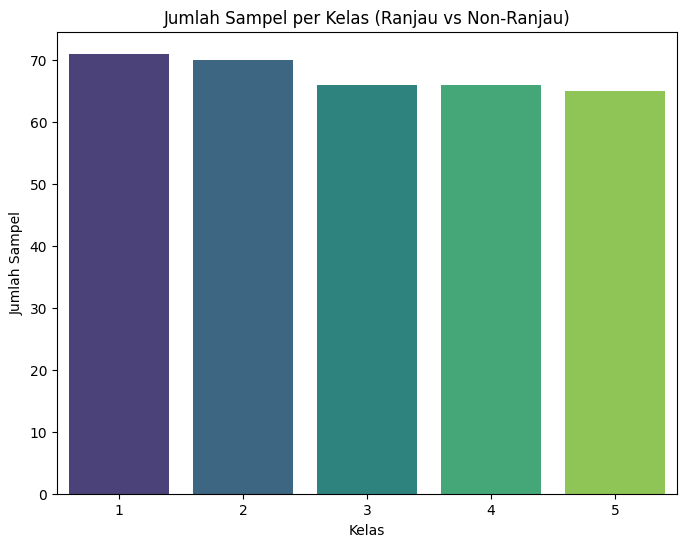

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo

# Load dataset Land Mines
land_mines = fetch_ucirepo(id=763)

# Ambil data fitur dan target
X = land_mines.data.features
y = land_mines.data.targets

# Gabungkan fitur dan target menjadi satu DataFrame
df_landmines = pd.concat([X, y], axis=1)

# Cek nama kolom target
print("Nama kolom target:", y.columns)

# Visualisasi jumlah sampel per kelas
plt.figure(figsize=(8, 6))
sns.countplot(x=y.columns[0], data=df_landmines, palette='viridis')
plt.title('Jumlah Sampel per Kelas (Ranjau vs Non-Ranjau)')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Sampel')
plt.show()


**Visualisasi Distribusi Fitur dengan Histogram**

<Figure size 1200x1000 with 0 Axes>

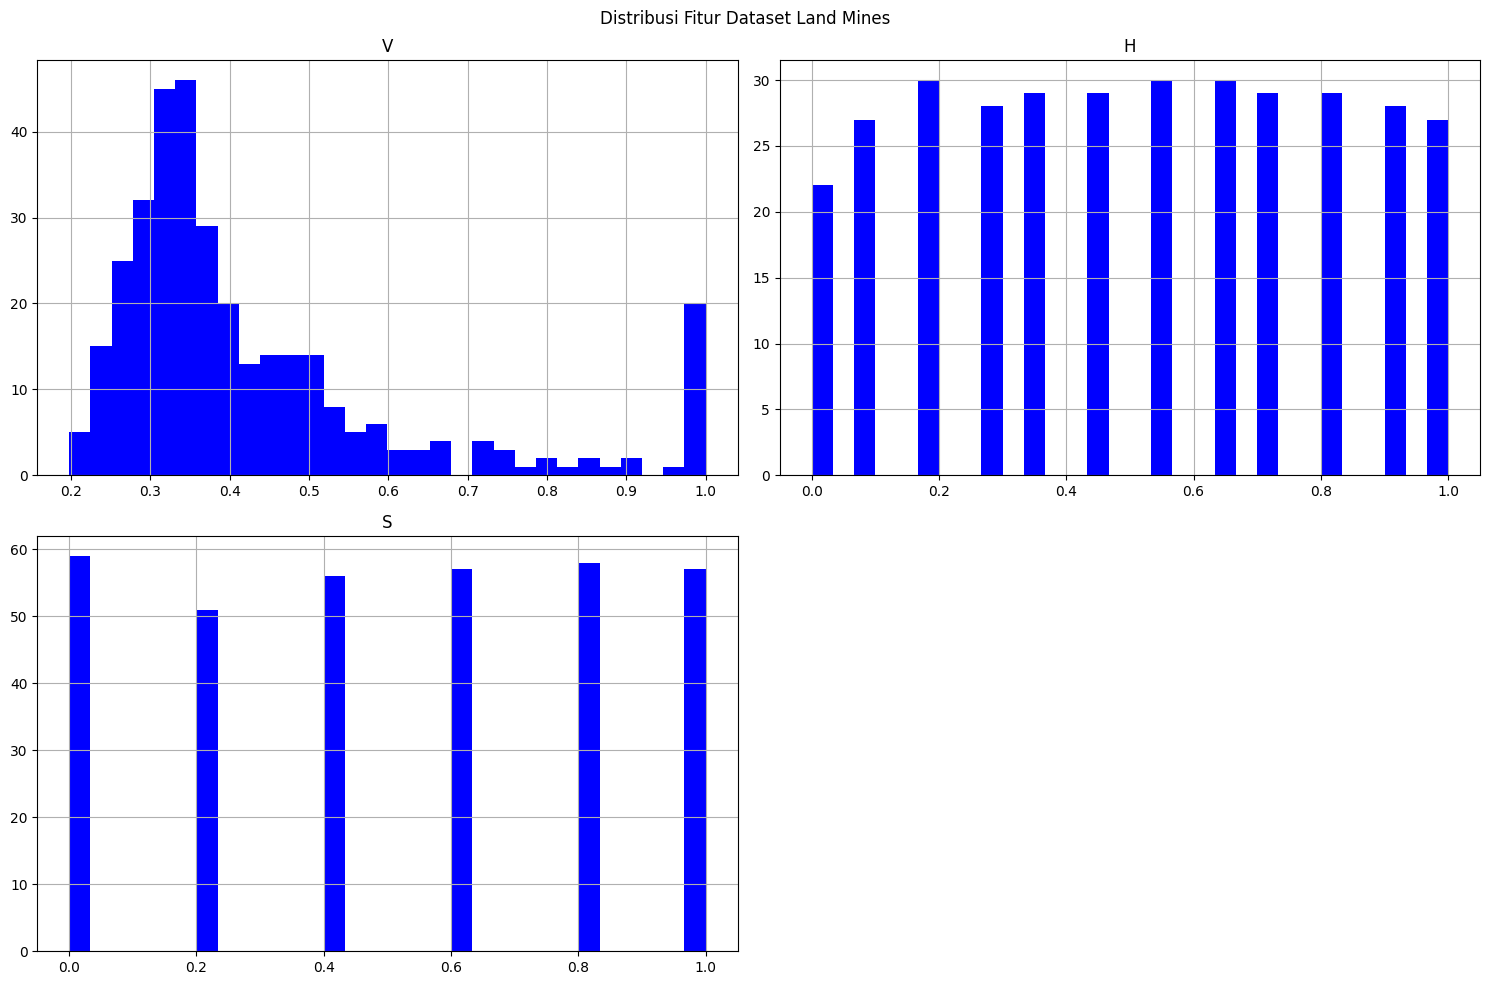

In [7]:
plt.figure(figsize=(12, 10))
df_landmines.drop(columns=y.columns[0]).hist(bins=30, figsize=(15, 10), color='blue')
plt.suptitle('Distribusi Fitur Dataset Land Mines')
plt.tight_layout()
plt.show()


**Visualisasi Boxplot untuk Deteksi Outlier**



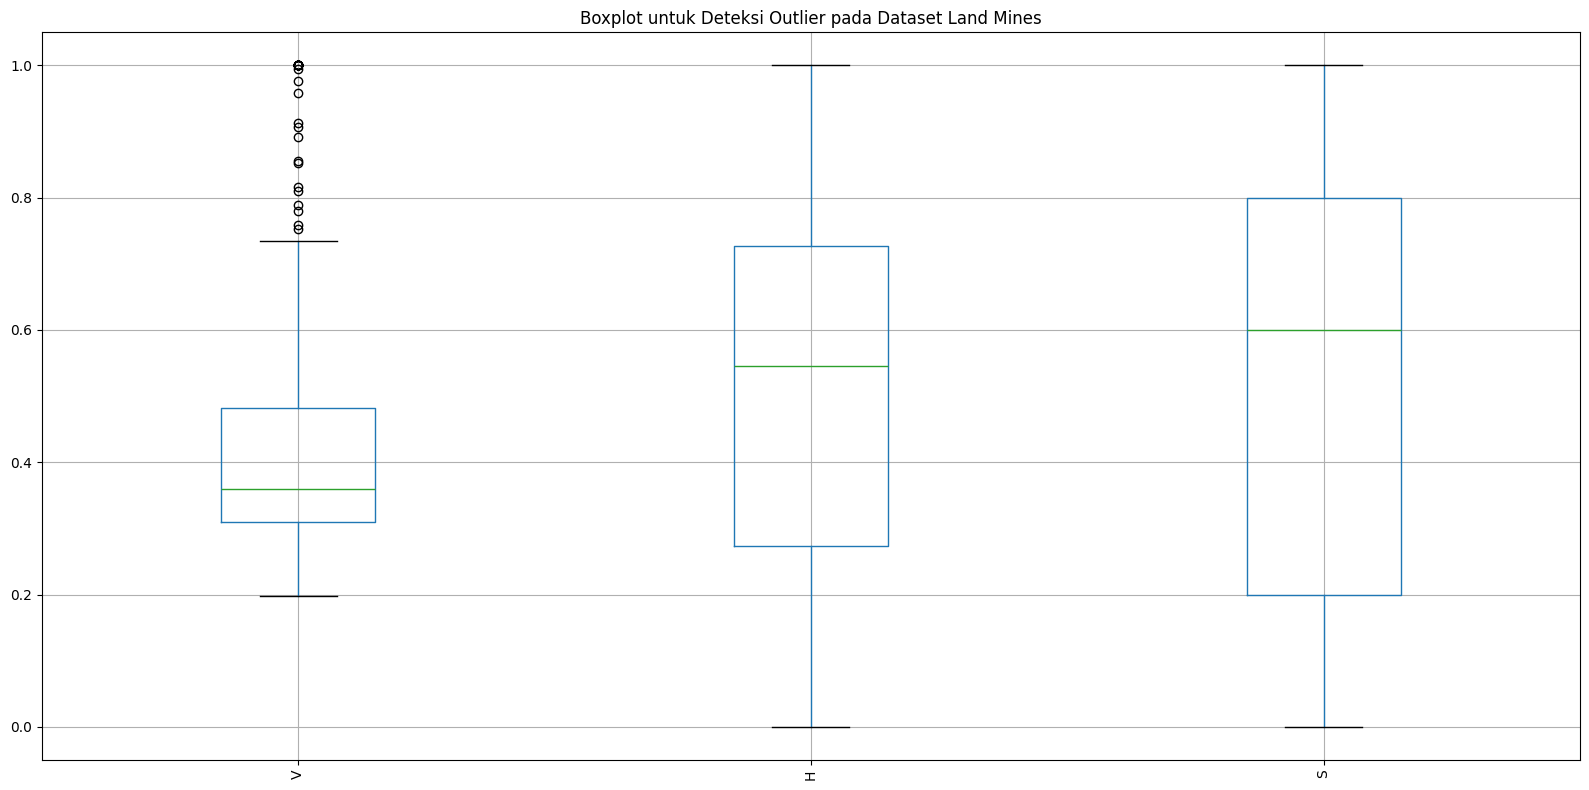

In [8]:
plt.figure(figsize=(16, 8))
df_landmines.drop(columns=y.columns[0]).boxplot(rot=90)
plt.title("Boxplot untuk Deteksi Outlier pada Dataset Land Mines")
plt.tight_layout()
plt.show()


### Penjelasan Fitur dan Variabel

#### Dataset Land Mines Sensor ASTAMIDS

Dataset ini berisi data hasil penginderaan jauh (remote sensing) menggunakan sistem sensor **ASTAMIDS** (Airborne Standoff Minefield Detection System) yang digunakan untuk mendeteksi keberadaan **ranjau darat**. Data dikumpulkan dari wilayah konflik di Kamboja dan terdiri dari fitur-fitur numerik yang mewakili sinyal spektral dari berbagai jenis objek di permukaan tanah. Tujuan utama dari dataset ini adalah untuk **mengklasifikasikan apakah suatu objek merupakan ranjau atau bukan**.

#### Variabel Independen (Fitur)

| Nama Fitur | Tipe Data | Kategori | Deskripsi                                                                 |
|------------|-----------|----------|---------------------------------------------------------------------------|
| `V`        | float64   | Numerik  | Representasi nilai spektral vertikal (vertical polarization reflectance) |
| `H`        | float64   | Numerik  | Representasi nilai spektral horizontal (horizontal polarization reflectance) |
| `S`        | float64   | Numerik  | Nilai spektral dari kombinasi sinyal spektrum (spectral signature)       |
| `M`        | float64   | Numerik  | Metode gabungan fitur (kemungkinan magnitude atau kombinasi sinyal spektral) |

#### Variabel Dependen (Label / Target Output)

| Nama     | Tipe Data | Tipe Kategori     | Deskripsi                                                                 |
|----------|-----------|-------------------|---------------------------------------------------------------------------|
| `class`  | int64     | Kategorikal Biner | Label klasifikasi objek: <br>0 = Non-Mine (bukan ranjau)<br>1 = Mine (ranjau darat terdeteksi) |



In [9]:
data.shape

(338, 4)

Terdapat 338 baris dan 4 kolom pada dataset Land Mines

## Preprocessing Data

### Transformasi Data

Dataset Land Mines memiliki label kelas pada kolom class yang berupa angka 0 dan 1, yang masing-masing mewakili dua kategori objek: bukan ranjau (non-mine) dan ranjau darat (mine). Angka-angka tersebut adalah representasi numerik dari dua kelas berbeda dalam konteks klasifikasi biner.

Untuk mempermudah interpretasi hasil klasifikasi dan visualisasi, label numerik pada kolom class diubah menjadi label kategorikal, yaitu:

0 → Non-Mine

1 → Mine



In [10]:
from ucimlrepo import fetch_ucirepo
import pandas as pd

# Ambil dataset Land Mines
land_mines = fetch_ucirepo(id=763)

# Buat DataFrame awal
data_before = pd.concat([land_mines.data.features, land_mines.data.targets], axis=1)

# Tampilkan nama kolom target
print("Nama kolom target:", land_mines.data.targets.columns[0])

# Ubah target numerik menjadi label kelas
# 0 = Non-Mine, 1 = Mine
target_mapping = {0: 'Non-Mine', 1: 'Mine'}
target_col = land_mines.data.targets.columns[0]
data_before[target_col] = data_before[target_col].replace(target_mapping)
pd.set_option('display.expand_frame_repr', False)

# Tampilkan data hasil transformasi
# print(data_before)


Nama kolom target: M


### Normalisai Data

Normalisasi datase menggunakan StandarScaler

In [11]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Gabungkan fitur dan target menjadi satu DataFrame
df = pd.concat([X, y], axis=1)

# Tampilkan nama kolom target
target_col = y.columns[0]

# Encode kolom target (label klasifikasi: Non-Mine, Mine → 0, 1)
le = LabelEncoder()
df[target_col] = le.fit_transform(df[target_col])  # Non-Mine → 0, Mine → 1

# Pisahkan fitur dan label
X = df.drop(columns=target_col)  # fitur numerik
y = df[target_col]               # label klasifikasi

# Scaling (standarisasi fitur)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


### Split Data Training dan Testing

In [12]:
from sklearn.model_selection import train_test_split

# Split data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,      # fitur yang sudah di-scaling
    y,             # label target (0 = Non-Mine, 1 = Mine)
    test_size=0.2, # 20% data untuk pengujian
    random_state=42
)


### Visualisasi Data Setelah Preprocessing

In [13]:
# Gabungkan kembali fitur (X) dan label (y) ke dalam satu DataFrame
df_landmines_combined = pd.concat([X, y], axis=1)

# Tampilkan total baris data
print("Total baris dataset ini adalah =", len(df_landmines_combined))

# Visualisasi isi dataset setelah digabung dengan label target
print("Visualisasi dataset Land Mines setelah digabung dengan label target:")
print(df_landmines_combined.to_string(index=False))


Total baris dataset ini adalah = 338
Visualisasi dataset Land Mines setelah digabung dengan label target:
       V        H   S  M
0.338157 0.000000 0.0  0
0.320241 0.181818 0.0  0
0.287009 0.272727 0.0  0
0.256284 0.454545 0.0  0
0.262840 0.545455 0.0  0
0.240966 0.727273 0.0  0
0.254410 0.818182 0.0  0
0.234924 1.000000 0.0  0
0.353474 0.000000 0.6  0
0.335347 0.181818 0.6  0
0.335347 0.272727 0.6  0
0.330030 0.454545 0.6  0
0.335347 0.545455 0.6  0
0.305136 0.727273 0.6  0
0.256284 0.818182 0.6  0
0.235649 1.000000 0.6  0
0.315347 0.000000 0.2  0
0.283988 0.181818 0.2  0
0.303262 0.272727 0.2  0
0.274924 0.454545 0.2  0
0.260030 0.545455 0.2  0
0.259818 0.727273 0.2  0
0.283988 0.818182 0.2  0
0.265861 1.000000 0.2  0
0.323051 0.000000 0.8  0
0.305136 0.181818 0.8  0
0.314199 0.272727 0.8  0
0.302114 0.454545 0.8  0
0.323262 0.545455 0.8  0
0.314199 0.727273 0.8  0
0.323262 0.818182 0.8  0
0.274199 1.000000 0.8  0
0.347432 0.000000 0.4  0
0.341692 0.181818 0.4  0
0.296072 0.272727 0

In [14]:
# Simpan dataset Land Mines yang sudah digabung ke file CSV
df_landmines_combined.to_csv('data_landmines.csv', index=False)

## Modelling

Modeling adalah proses membangun dan mengembangkan model matematis dan statistik untuk merepresentasikan struktur dan pola dalam suatu kumpulan data. Dalam konteks data mining, modeling digunakan untuk memahami hubungan antar variabel serta membuat prediksi terhadap data baru yang belum terlihat sebelumnya.

Tujuan utama dari modeling adalah menghasilkan model yang akurat sehingga dapat digunakan untuk pengambilan keputusan yang berbasis data, baik dalam bentuk klasifikasi, regresi, clustering, atau jenis analisis lainnya. Proses ini biasanya melibatkan pemilihan algoritma yang sesuai, pelatihan model menggunakan data historis, dan evaluasi performa model.

### Modelling Klasifikasi Menggunakan Decision Tree

Model klasifikasi Decision Tree Classifier merupakan salah satu metode supervised learning yang berbasis aturan dan struktur pohon bercabang. Setiap cabang pada pohon merepresentasikan keputusan berdasarkan nilai fitur, dan setiap daun pada pohon menunjukkan hasil klasifikasi.

**Langkah-Langkah Modelling: Deteksi Ranjau Darat dengan Decision Tree**

1. **Pembagian Dataset: Data Training dan Data Testing**

Langkah pertama dalam pemodelan adalah membagi data menjadi dua bagian:

- **Data Latih (Training Set):** digunakan untuk melatih model.
- **Data Uji (Testing Set):** digunakan untuk mengevaluasi performa model terhadap data baru yang belum pernah dilihat sebelumnya.

Dalam eksperimen ini digunakan rasio **80% data latih** dan **20% data uji** menggunakan fungsi `train_test_split`.


2. **Pra-pemrosesan Data**

Sebelum data dimasukkan ke dalam model Decision Tree, dilakukan beberapa tahapan pra-pemrosesan:

- **Label target** (`class`) yang semula berupa string **'Non-Mine'** dan **'Mine'** diubah menjadi bentuk numerik **0 dan 1** menggunakan Label Encoding.
- **Fitur numerik** (`V`, `H`, `S`, `M`) telah distandarisasi menggunakan `StandardScaler` agar setiap fitur berada dalam skala yang sebanding.

3. **Pelatihan Model**

Model Decision Tree dibangun dengan prinsip membagi data pada setiap node berdasarkan fitur yang **paling efektif memisahkan kelas** (berdasarkan pengukuran impurity seperti **Gini Index**).

Model dipisahkan secara rekursif hingga mencapai:

- **Kriteria:** `'gini'` (untuk mengukur kualitas pemisahan)
- **Kedalaman maksimum (max_depth):** `5`, untuk mencegah overfitting dan menjaga interpretabilitas model.

4. **Evaluasi Model**

Setelah model dilatih, performanya dievaluasi menggunakan beberapa metrik:

- **Akurasi:** Persentase prediksi yang benar dari total data uji.
- **Classification Report:** Meliputi precision, recall, dan F1-score untuk masing-masing kelas (`Mine` dan `Non-Mine`).
- **Confusion Matrix:** Untuk melihat seberapa baik model membedakan antara ranjau dan bukan ranjau.


5. **Prediksi Kelas Objek**

Setelah proses pelatihan dan evaluasi selesai, model dapat digunakan untuk:

- **Memprediksi** apakah suatu objek merupakan ranjau atau bukan berdasarkan sinyal spektral dari sensor.
- **Mengidentifikasi fitur paling berpengaruh** dalam klasifikasi (misalnya fitur `V` yang terdeteksi memiliki outlier).


6. **Visualisasi Pohon Keputusan**

/tmp/ipython-input-23-1567105041.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace({'Non-Mine': 0, 'Mine': 1})


Label unik setelah pembersihan: [np.int64(0), np.int64(1)]
Akurasi: 1.0

=== Classification Report ===
              precision    recall  f1-score   support

    Non-Mine       1.00      1.00      1.00        16
        Mine       1.00      1.00      1.00        13

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29



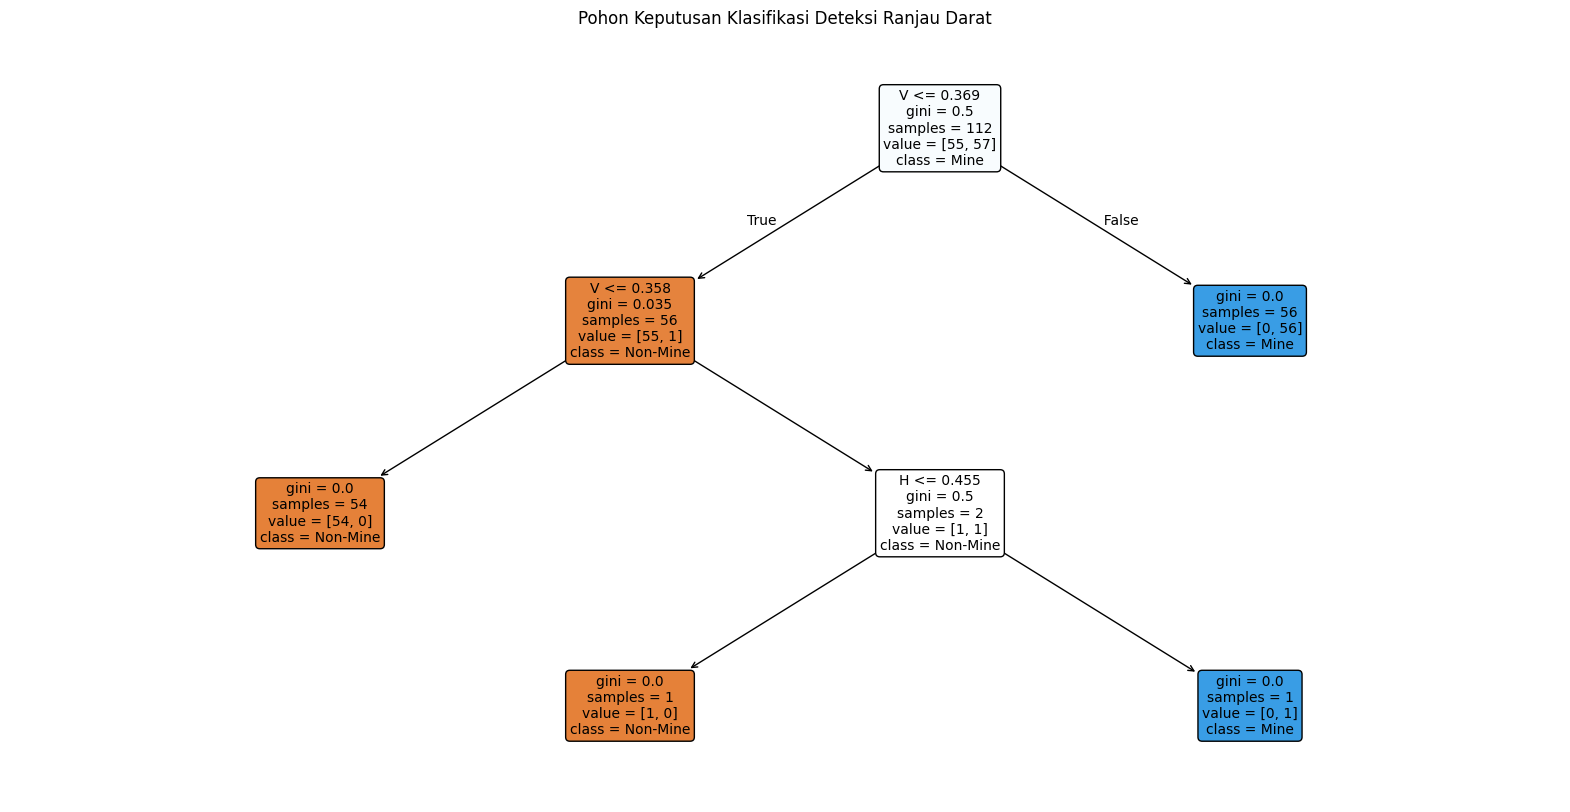

In [23]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

# 1. Ubah label menjadi 0 dan 1, hilangkan yang tidak valid
y = y.replace({0: 'Non-Mine', 1: 'Mine', 2: 'ERROR', 3: 'ERROR', 4: 'ERROR'})
y = y.replace({'Non-Mine': 0, 'Mine': 1})

# 2. Reset index untuk memastikan sinkronisasi
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

# 3. Filter hanya data yang label-nya 0 atau 1
valid_index = y.isin([0, 1])
X = X[valid_index]
y = y[valid_index]

# 4. Pastikan y adalah Series bertipe int (1D)
y = y.astype(int)
y = pd.Series(y.values.ravel())

print("Label unik setelah pembersihan:", sorted(y.unique()))

# 5. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 6. Training Decision Tree
clf = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=42)
clf.fit(X_train, y_train)

# 7. Evaluasi
y_pred = clf.predict(X_test)
print("Akurasi:", accuracy_score(y_test, y_pred))

print("\n=== Classification Report ===")
target_names = ['Non-Mine', 'Mine']
print(classification_report(y_test, y_pred, target_names=target_names))

# 8. Visualisasi Pohon Keputusan
plt.figure(figsize=(20, 10))
plot_tree(
    clf,
    feature_names=X.columns,
    class_names=target_names,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Pohon Keputusan Klasifikasi Deteksi Ranjau Darat")
plt.show()


### Modelling Klasifikasi Menggunakan Gaussian Naive Bayes
Gaussian Naive Bayes (GNB) adalah algoritma klasifikasi berbasis probabilistik yang digunakan dalam machine learning untuk memprediksi kelas suatu data berdasarkan fitur-fitur numerik. GNB merupakan varian dari algoritma Naive Bayes yang mengasumsikan bahwa nilai dari setiap fitur mengikuti distribusi normal (Gaussian).

Pada pemodelan ini, tujuan utama adalah untuk mengklasifikasikan apakah suatu titik data mewakili keberadaan ranjau (mine) atau bukan (non-mine) berdasarkan fitur numerik hasil pengukuran sensor. Fitur-fitur ini bisa mencakup nilai amplitudo gelombang (V, H, S) dan informasi medan (M).

Dataset Land Mines terdiri dari dua kelas:

0 = Non-Mine (bukan ranjau),

1 = Mine (ranjau darat).

**Langkah-langkah modelling:**

1. **Pembagian dataset : data training dan data testing**

Langkah awal dalam proses pemodelan adalah membagi dataset menjadi dua bagian:

- **Data Latih (Training set)** digunakan untuk melatih model Gaussian Naive Bayes.  
- **Data Uji (Testing set)** digunakan untuk mengevaluasi kemampuan generalisasi model terhadap data yang belum pernah dilihat sebelumnya.

Dalam eksperimen ini, digunakan rasio **80% data training dan 20% data testing**.

2. **Menghitung probabilitas awal (prior probability)**

Selanjutnya hitung probabilitas awal (prior) untuk masing-masing kelas:

- Hitung jumlah data latih untuk setiap kelas (**Non-Mine** dan **Mine**).  
- Bagi dengan total jumlah data latih.

Nilai ini menunjukkan seberapa besar kemungkinan suatu data merupakan ranjau atau bukan **tanpa melihat fitur apapun**.


3. **Menghitung rata-rata dan standar deviasi tiap fitur**

Setelah prior diketahui, untuk setiap kelas (Non-Mine dan Mine), model menghitung:

- **Rata-rata (mean)** untuk masing-masing fitur numerik seperti `V`, `H`, `S`, dan `M`.  
- **Standar deviasi (standard deviation)** dari setiap fitur pada kelas tersebut.

4. **Menghitung distribusi gaussian**

Distribusi ini digunakan untuk menghitung seberapa besar kemungkinan nilai fitur tersebut muncul dalam sebuah kelas.

Setiap nilai fitur akan dimasukkan ke dalam rumus distribusi Gaussian berikut:

$$
P(x|\mu,\sigma) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left( -\frac{(x - \mu)^2}{2\sigma^2} \right)
$$

Dimana:

- $x$: nilai fitur input  
- $\mu$: rata-rata fitur pada kelas tertentu  
- $\sigma$: standar deviasi fitur pada kelas tertentu

5. **Menghitung posterior probability**

Dengan mengalikan semua hasil distribusi Gaussian dan dikalikan dengan prior dari kelas, diperoleh nilai **posterior probability** untuk masing-masing kelas:

$$
\text{Posterior} = P(x_1|C_i) \cdot P(x_2|C_i) \cdot \ldots \cdot P(x_n|C_i) \cdot P(C_i)
$$

Dimana:

- $P(x_k|C_i)$: hasil distribusi Gaussian dari fitur ke-k pada kelas $C_i$  
- $P(C_i)$: prior probability dari kelas $C_i$

Model kemudian akan memilih **kelas dengan nilai posterior tertinggi** sebagai **prediksi akhir** (ranjau atau bukan ranjau).


Akurasi: 1.0

=== Classification Report ===
              precision    recall  f1-score   support

    Non-Mine       1.00      1.00      1.00        16
        Mine       1.00      1.00      1.00        13

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29



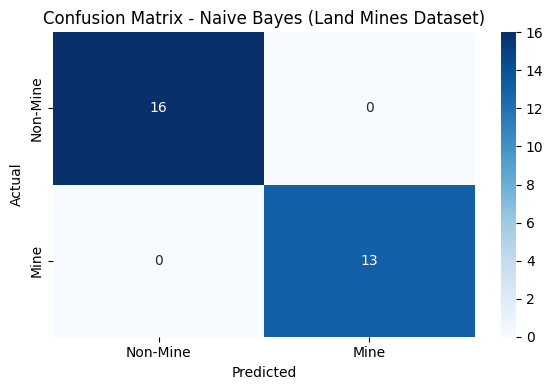

In [24]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Latih model Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# 2. Evaluasi hasil prediksi
y_pred = gnb.predict(X_test)

print("Akurasi:", accuracy_score(y_test, y_pred))

print("\n=== Classification Report ===")
target_names = ['Non-Mine', 'Mine']
print(classification_report(y_test, y_pred, target_names=target_names))

# 3. Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=gnb.classes_)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=target_names,
            yticklabels=target_names,
            cmap='Blues')

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Naive Bayes (Land Mines Dataset)")
plt.tight_layout()
plt.show()


### Modelling Klasifikasi Menggunakan K-Nearest Neighbor (K-NN)

Model **K-Nearest Neighbors (KNN)** digunakan dalam pemodelan ini untuk memprediksi apakah suatu sampel merupakan **ranjau darat (Mine)** atau **bukan ranjau (Non-Mine)** berdasarkan fitur-fitur numerik hasil pengukuran sensor seperti `V`, `H`, `S`, dan `M`.

KNN merupakan metode pembelajaran berbasis instance (**instance-based learning**) yang tidak membentuk model eksplisit selama pelatihan. Sebaliknya, KNN menyimpan seluruh data pelatihan, dan melakukan prediksi terhadap data baru dengan mencari sejumlah *k* tetangga terdekat di ruang fitur menggunakan metrik jarak, seperti **Euclidean Distance**.

Dalam konteks klasifikasi ranjau darat, KNN akan mengklasifikasikan sampel baru berdasarkan mayoritas kelas dari tetangga-tetangganya. Jika sebagian besar tetangga adalah “Mine”, maka data tersebut juga diprediksi sebagai “Mine”, dan sebaliknya.



**Langkah-langkah Modelling K-Nearest Neighbors (KNN)**

1. **Pembagian dataset: training dan testing**

Langkah awal dalam proses pemodelan adalah membagi dataset menjadi dua bagian:

- **Data Latih (Training set)** digunakan sebagai referensi (tetangga-tetangga) untuk proses klasifikasi.
- **Data Uji (Testing set)** digunakan untuk menguji performa model terhadap data baru yang belum pernah dilihat sebelumnya.

Dalam eksperimen ini, digunakan rasio **80% data training dan 20% data testing**.

2. **Pra-pemrosesan data**

Agar algoritma KNN bekerja secara optimal, dilakukan beberapa tahapan pra-pemrosesan berikut:

**a. Encoding Label Kelas (Target)**

- Label kelas (target) pada dataset Land Mines awalnya berupa nilai 0 hingga 4.
- Namun, hanya kelas **0 (Non-Mine)** dan **1 (Mine)** yang digunakan dalam pemodelan ini.
- Label-label yang tidak valid (selain 0 dan 1) dibuang untuk menjaga fokus pada klasifikasi biner.

**b. Scaling / Normalisasi**

- Fitur numerik seperti `V`, `H`, `S`, dan `M` memiliki skala yang berbeda-beda.
- Karena KNN sangat sensitif terhadap skala fitur, digunakan **StandardScaler** untuk menstandarkan data agar setiap fitur memiliki distribusi seragam (**mean = 0** dan **standard deviation = 1**).

3. **Konsep Kerja KNN**

Berbeda dengan model prediktif berbasis fungsi, KNN hanya menyimpan data latih dan membuat keputusan berdasarkan kedekatan data:

1. Hitung jarak (biasanya **Euclidean**) dari data uji ke seluruh data latih.
2. Ambil **k tetangga terdekat** berdasarkan jarak tersebut.
3. Lakukan **voting mayoritas**: kelas yang paling sering muncul di antara tetangga tersebut menjadi prediksi.

Contoh:

Jika **k = 5** dan 3 dari 5 tetangga terdekat adalah kelas **Mine**, maka data tersebut diprediksi sebagai **Mine**.


4. **Evaluasi Model**

Untuk mengukur performa model KNN, dilakukan evaluasi menggunakan:

- **Akurasi**: rasio jumlah prediksi benar terhadap total data uji.
- **Classification Report**: mencakup metrik **precision**, **recall**, dan **F1-score** untuk masing-masing kelas (Non-Mine dan Mine).
- **Confusion Matrix**: menunjukkan detail jumlah prediksi benar dan salah untuk masing-masing kelas.

Akurasi: 0.896551724137931

=== Classification Report ===
              precision    recall  f1-score   support

    Non-Mine       0.88      0.94      0.91        16
        Mine       0.92      0.85      0.88        13

    accuracy                           0.90        29
   macro avg       0.90      0.89      0.89        29
weighted avg       0.90      0.90      0.90        29



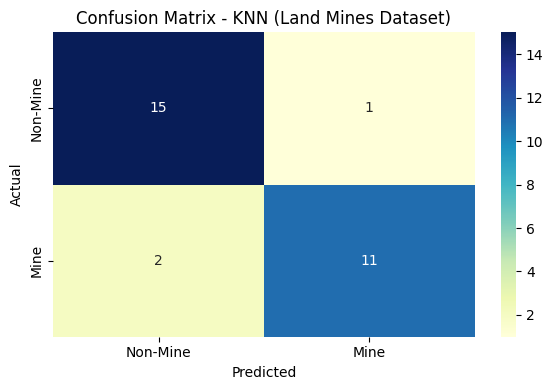

In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Latih model KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# 2. Evaluasi model
y_pred = knn.predict(X_test)

print("Akurasi:", accuracy_score(y_test, y_pred))

print("\n=== Classification Report ===")
target_names = ['Non-Mine', 'Mine']
print(classification_report(y_test, y_pred, target_names=target_names))

# 3. Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=knn.classes_)

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    xticklabels=target_names,
    yticklabels=target_names,
    cmap='YlGnBu'
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - KNN (Land Mines Dataset)")
plt.tight_layout()
plt.show()


## Evaluasi Data

Dari hasil evaluasi terhadap tiga model klasifikasi pada dataset Land Mines, diperoleh nilai akurasi sebagai berikut:

Decision Tree = 100,00%

Gaussian Naive Bayes = 100,00%

K-Nearest Neighbor (KNN) = 89,66%

Berdasarkan nilai akurasi tersebut, dapat disimpulkan bahwa Decision Tree dan Gaussian Naive Bayes menunjukkan performansi terbaik, dengan akurasi sempurna pada seluruh data uji. Kedua model ini berhasil mengklasifikasikan seluruh sampel dengan tepat, tanpa kesalahan, baik untuk kelas Mine maupun Non-Mine.

Sementara itu, K-Nearest Neighbor (KNN) menunjukkan akurasi yang masih sangat baik, yaitu sekitar 90%, namun terdapat sedikit kesalahan dalam mengklasifikasikan beberapa sampel, khususnya pada kelas Mine, yang menyebabkan nilai recall-nya sedikit lebih rendah dibandingkan kelas Non-Mine.

Meskipun demikian, KNN tetap merupakan alternatif yang solid, khususnya jika tuning nilai k dilakukan secara optimal.


